# Optimizing a chemical reaction

As a very simple example of optimizing a chemical reaction, we try to find the
mix of universal indicator, acid and base that gives the best green color. While this
is a very simple experiment, it shows the general approach one would follow in
optimizing a chemical reaction according to yield or purity.

We have made a full factorial mix of different levels of indicator while varying the percentage of acid (`V(acid)/(V(acid) + V(base))*100 %`),
and measured the resulting color:

![Full factorial indicator and acid mix in a plate](../ProcessOptimizer/model_systems/data/color_pH_image.jpg)

When in the lab, you would normally do one experiment at a time. To simulate this, we have
made it possible to look up the result from any recipe. In other words, we can do theoretical
experiments that mimic what you would see if you were to
do laboratory experiments one at a time. This behavior is
captured by the model system color_pH.

We first set up the parameter space:

In [1]:
import ProcessOptimizer as po

search_space = [
       po.Integer(30,85, name="pct_acid"),
       po.Integer(5,40, name="vol_indicator")
       ]


We can then set up the processOptimizer:

In [2]:
opt = po.Optimizer(search_space, n_initial_points=4)

We can now ask the optimizer to suggest the next recipe to try, and use the
model system to simulate following the recipe and telling us how good
the result is:

In [3]:
# Get the first suggested experiment
next_recipe = opt.ask()
print(("Next suggested experiment has "
      + str(next_recipe[0])
      + " percent acid and "
      + str(next_recipe[1])
      + " μL indicator."))



Next suggested experiment has 79 percent acid and 36 μL indicator.


## Using the model system separately

The model system has a method called `get_score()` which simulates following the recipe,
measuring the resulting color, and evaluating how close it is to the wanted color.

In a lab setting, you would run the experiment instead, and record the results.

We also start saving the recipes simulated and their resulting qualities.

In [4]:
model_system = po.model_systems.color_pH
# Run the experiment and get the result
quality = model_system.get_score(next_recipe)

recipe_and_result_list = [(next_recipe, quality)]

print(f"Following the recipe lead to a quality of {quality:.2f}")

Following the recipe lead to a quality of 50.82


Now, we can tell the optimizer about the recipe we just "followed".

In [5]:
result = opt.tell(next_recipe, quality)

We can keep doing this for a few runs.

In [6]:
for i in range(7):
    next_recipe = opt.ask()
    quality = model_system.get_score(next_recipe)
    recipe_and_result_list.append((next_recipe, quality))
    result = opt.tell(next_recipe, quality)

## Plotting
Finally, we can plot the result object to inspect the model.

### Plot Objective in n-dimensions

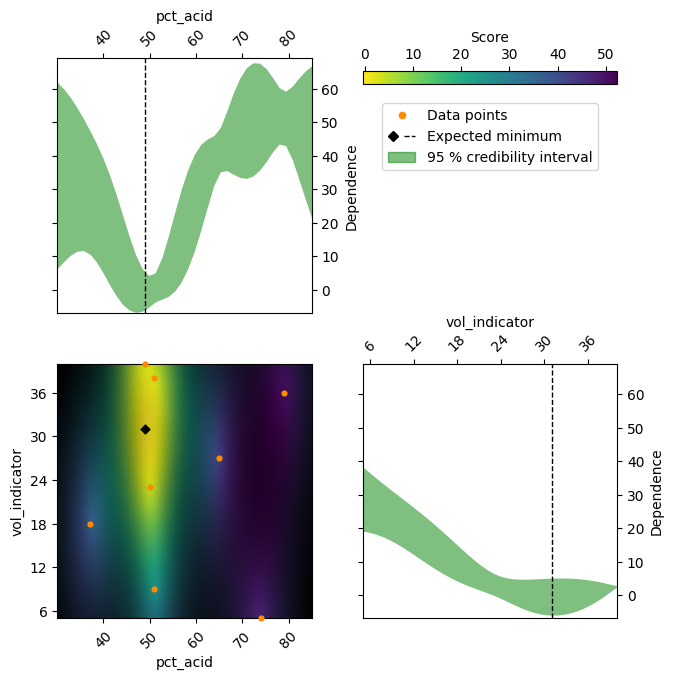

In [7]:
# Make additional plot with measurement uncertainty

po.plot_objective(result,
                  pars = 'expected_minimum',
                  plot_options = {"interpolation": "bicubic"},
                  );

The 2D plot shows the model when two parameters are changed. In this example, there are only two parameters, so that is the entire model. In models with more parameters, the dependency on each pair of variables would be shown as separate 2D plots. This plotting type scales to any number of parameters, including real, integer and categorical parameters. Though keywords and settings in "plot_options", this plot can show (or hide) the uncertainty of the model in both 1d graphs (the diagonal line of subplots) as well as 2d graphs (subplots in the lower left triagonal part of the plot). Furthermore, any projection of 1d plots can be called in situation where the experimenter might be interested in locking one control parameter and choosing the optimal setting of the other parameters; this is done through the "pars" keyword.

### Plot objective in 1d

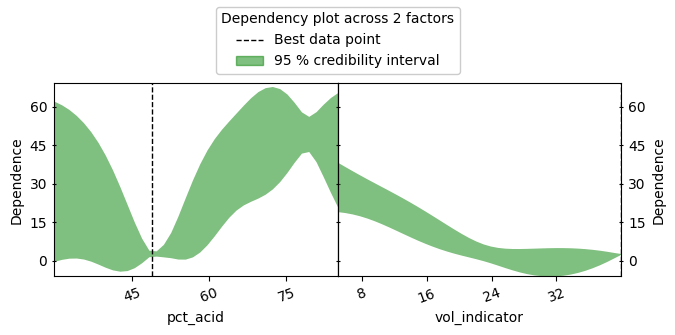

In [8]:
po.plots.plot_objective_1d(result);

A simpler, more clean plotting of the models expected outcome. Now, only 1d plots are shown. This is expected to highlight the importance of individual control features even further.

### Plot Evaluations

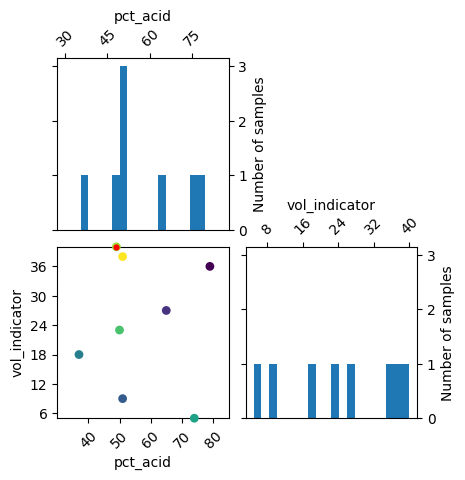

In [9]:
po.plot_evaluations(result);

Plot evaluations follows the same layout and structure as plot_objective (see above). It can be used as a fast visual check on whether the full x-space has been covered by experiments. The coloring of the dots in the 2d-plotting area show the sequence of experiments from dark blue (first experiment) through green to yellow. Latest experiment is marked in red.

### Plot Convergence

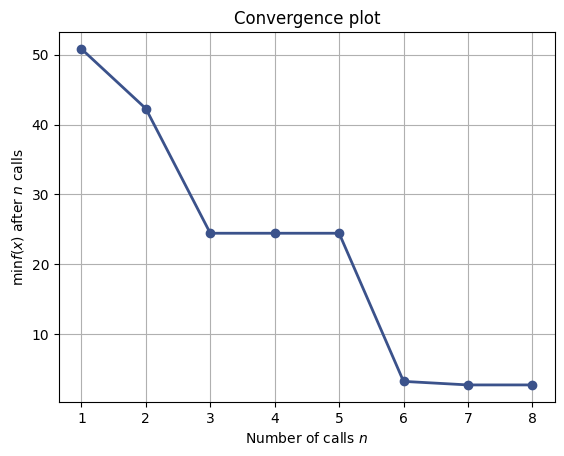

In [10]:
po.plot_convergence(result);

The convergence plot shows the best obtained result as a function of iteration. It is expected that the best observed result does not move at every iteration due to the neccesary explore/exploit trade-off when using Bayesian Optimization. Remember that the convergence plot will only show the best observed result, this might not reflect the models ability to predict a recipy that might produce even better results.

### Plot Regret

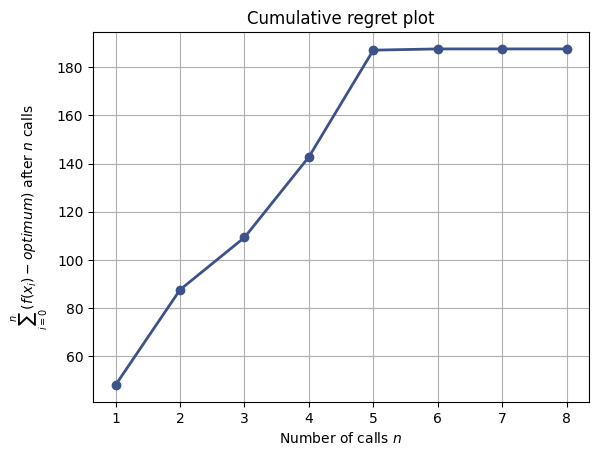

In [11]:
po.plots.plot_regret(result);

A cumulative regret plot will show the accumulated cost of not having run at the best settings from the start. Optimally seen, the accumulated cost should be as low as possible when the experimenter reaches a set of acceptable conditions for the process being optimized. The plot is very usefull, when comparing several optimization strategies.

### Experimental plots

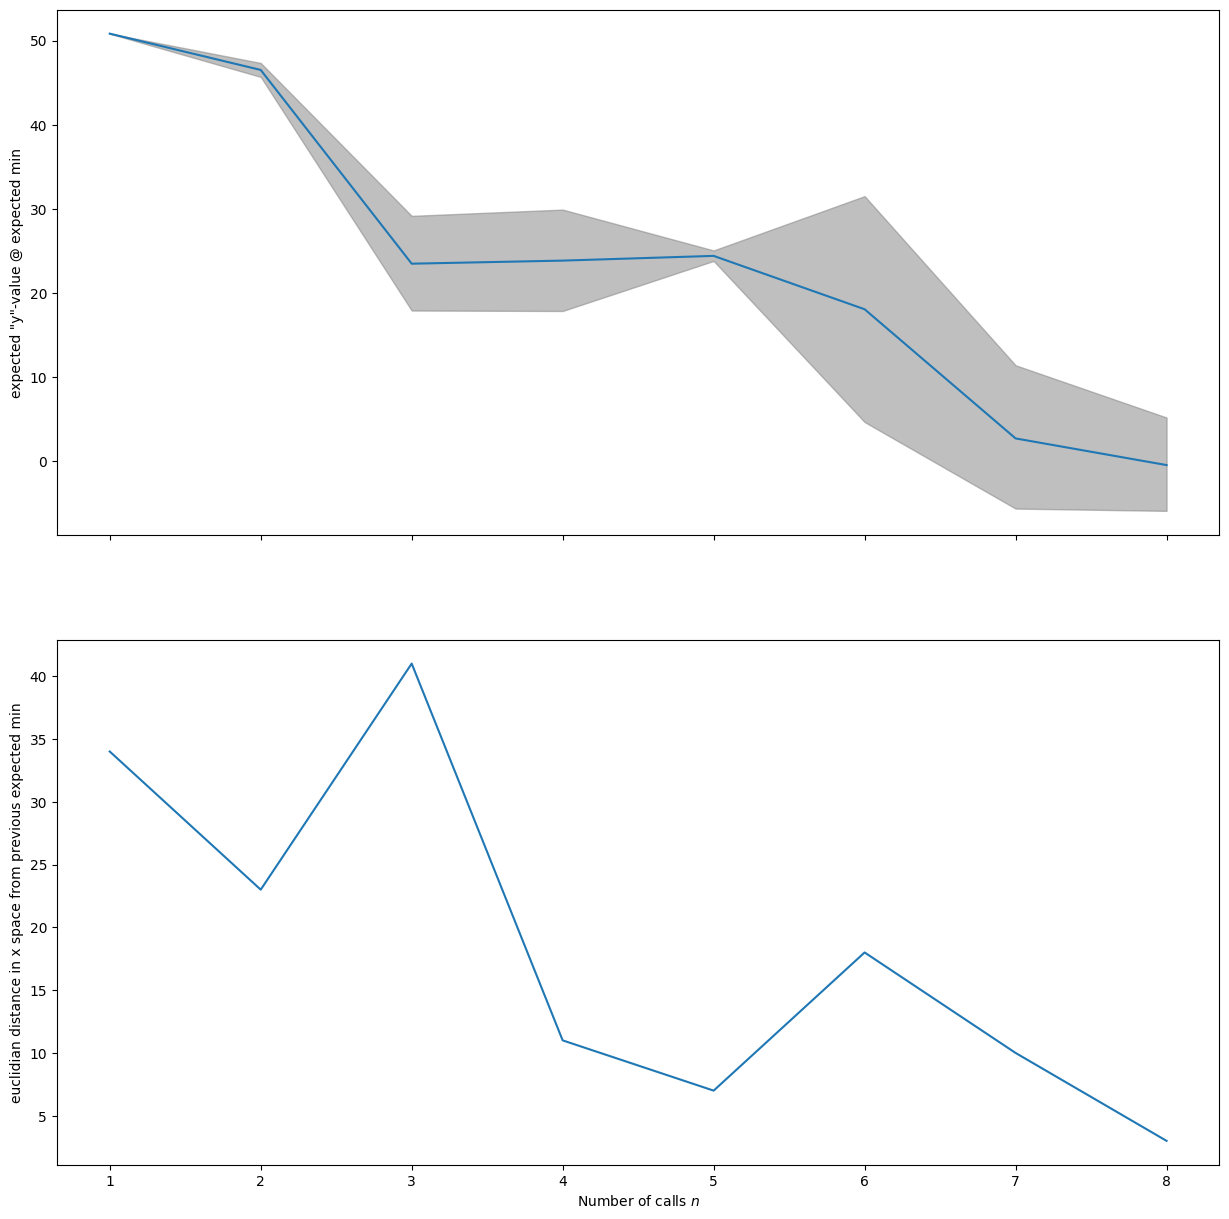

In [12]:
po.plot_expected_minimum_convergence(result, sigma=0.2);

The plot_expected_minimum_convergence plot (above) is a more exploratory plot. It is meant to help the user judge the progression of the optimization. The upper panel shows the expected value (incl model uncertainty) that can be reached by the process given the current model (as a function of interation number). The value should hopefully converge to a smaller number, while the model uncertainty should decrease as a signal for a more data covered and completed model. The lower panel shows the euclidian distance in the design-space of the experiments between the expected minimum at the current iteration compared to the previous iteration. In a case in which all factors have importance for the process, the lower panel should converge as a sign that the model converges towards a single perceived optimum. 

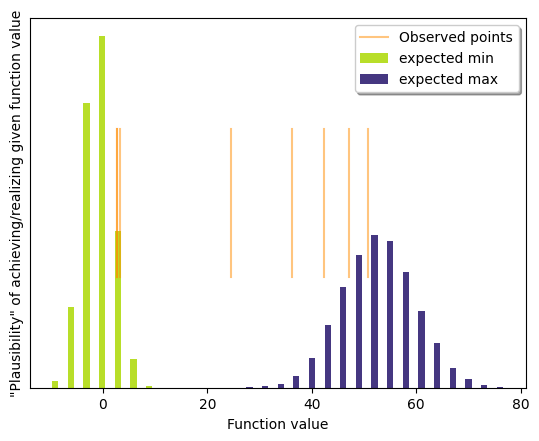

In [13]:
po.y_coverage(result, return_plot=True);

The plot y_coverage is another exploratory plot meant to convey an understanding of the model uncertainty and the underlaying data. Orange bars show the function values that has been told to the model, while two histograms show the current models uncertainty in the expected maximum and minimum values. Signs of a good model would be that the interesting extrema (the minimum in our case) is more data covered and has less uncertanty compared to the other extrema. Personally, I would tend to trust a model that has learned from data that has realised values close to the objective (a good minimum in our case).

### Additional plots
To demonstrate the plotting capabilities for multiobjective optimization, we can imagine a scenario in which the color indicator has a price that is a limit to out productivity (again, this is just an example to demonstrate functionality). In doing so, we start a new optimization in which we highlight that we have two objectives, and when we tell the results of a experiment, we now have to enter a list of measurements containing the score of the color as well as the cost of the color. As we are trying to learn two objectives (and their connection) we expect to need a few additional experiments. In the code below, we perform 10 experiments.

In [14]:
opt_multiobjective = po.Optimizer(search_space, n_objectives=2, n_initial_points=4, random_state=3)

recipe_and_result_list_multiobjective=[]

for i in range(10):
    next_recipe = opt_multiobjective.ask()
    quality_and_cost = [model_system.get_score(next_recipe),next_recipe[1]]
    recipe_and_result_list_multiobjective.append((next_recipe, quality_and_cost))
    result_multiobjective = opt_multiobjective.tell(next_recipe, quality_and_cost)

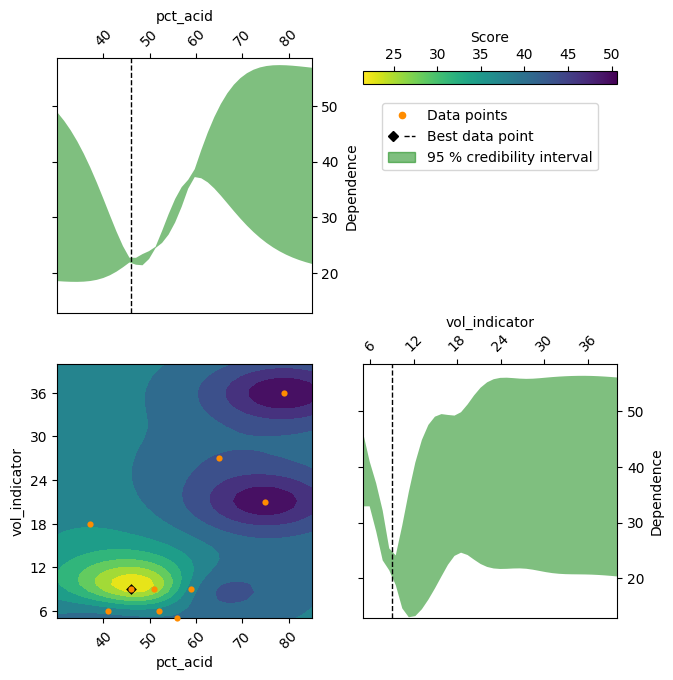

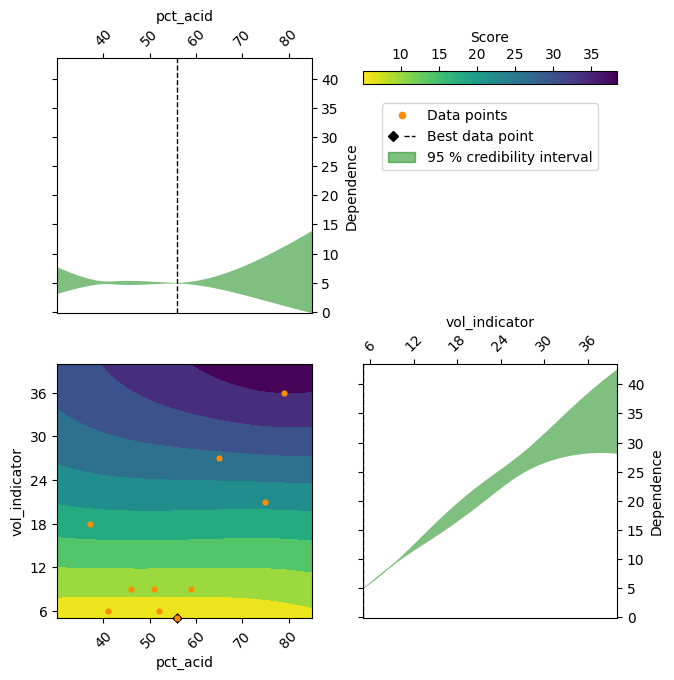

In [15]:
po.plot_objectives(result_multiobjective);

The first plot is a convenience functions that allows the user to plot the model for each objective defined in the experiment. As such plot_objectives() plots a list of plot_objective() plots (pay attention to the plural-s in the call of the function).

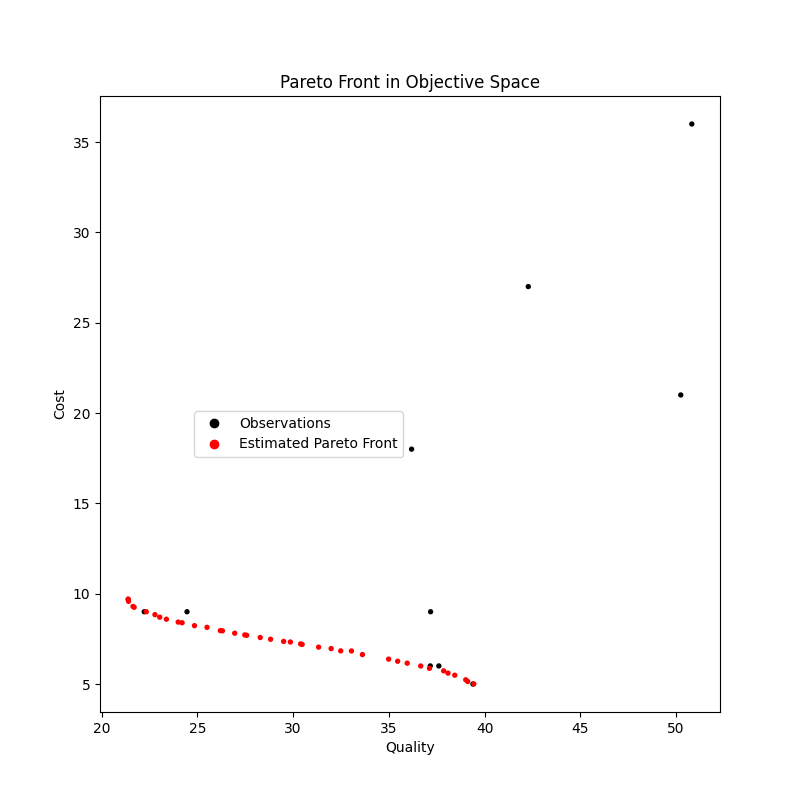

In [16]:
#ipympl is needed for the following cell to render. without ipympl, the user is still able to run po.plot_pareto(optimizer) but the plot will not be interactive.
%matplotlib widget
po.plot_Pareto(opt_multiobjective, figsize=(8,8), objective_names=["Quality", "Cost"]);

The pareto front can easily be plotting and will be interactive. As such, the user gets an overview of how the "quality" and the "cost" interact. Clearly, it is not possible to reach the intended green color without the use of indicator liqued (which is assumed to be the cost driver in this example). The black circles on the plot corresponds to realised, real experimental data. The red circles is the modelled pareto-front of the process i.e. the points at which one objective cannot be further improved without being at the cost of a detrimental effect to the other objective. The user can hover the mouse over any point to see the suggested experimental recipe can will lead to that specific result (given model correctness). <br>
Further plotting features of the pareto front is included in the package.

## Expected minimum
We can now find the expected minimum of the model:

In [17]:
expected_minimum = po.expected_minimum(result)
print(
    f"The expected minimum is {expected_minimum[0][0]} percent acid and "
    f"{expected_minimum[0][1]} μL indicator. It has an expected quality of "
    f"{expected_minimum[1]}."
)

The expected minimum is 49 percent acid and 31 μL indicator. It has an expected quality of -0.43872443872903943.


The true minimum is at 50 percent acid and 30 μL indicator, but since the experimental
mixtures are only made at whole multiples of 5 percent acid and 5 μL indicator, 49 percent
acid and 31 μL indicator gives the same quality.

The experimental quality at the true minimum is 0 by definition, so the model estimates a
bit better quality at the minimum.

## Table with overview of results

We can now make a table with an overview of the tested recipes and their results. Rember, lower score is better:

In [18]:
for recipe, quality in recipe_and_result_list:
    print({
        "pct_acid": recipe[0],
        "vol_indicator": recipe[1],
        "score": round(quality,1)
    })


{'pct_acid': 79, 'vol_indicator': 36, 'score': 50.8}
{'pct_acid': 65, 'vol_indicator': 27, 'score': 42.3}
{'pct_acid': 51, 'vol_indicator': 9, 'score': 24.5}
{'pct_acid': 37, 'vol_indicator': 18, 'score': 36.2}
{'pct_acid': 74, 'vol_indicator': 5, 'score': 47.1}
{'pct_acid': 50, 'vol_indicator': 23, 'score': 3.3}
{'pct_acid': 49, 'vol_indicator': 40, 'score': 2.8}
{'pct_acid': 51, 'vol_indicator': 38, 'score': 2.8}
